# Analyse ERA5 demand for NEM

In [69]:
import xarray as xr
import pandas as pd
import numpy as np
from xhistogram.xarray import histogram

import matplotlib.pyplot as plt

In [2]:
%cd /g/data/w42/dr6273/work/demand_model/

import functions as fn

/g/data/w42/dr6273/work/demand_model


In [3]:
%load_ext autoreload
%autoreload 2

### Set global variables

In [4]:
RESULTS_PATH = "/g/data/w42/dr6273/work/projects/Aus_energy/model_results/"

In [5]:
MARKET = "NEM" # "NEM" or "EU"

In [6]:
REMOVE_WEEKEND = True

In [7]:
REMOVE_XMAS = True

In [8]:
REMOVE_MONTH = 0 # integer: [1, 12]

In [9]:
MASK_NAME = "pop_dens_mask"

In [10]:
TIME_COLUMNS = []

In [11]:
FIRST_TRAIN_YEAR = 2010
LAST_TRAIN_YEAR = 2019

In [12]:
FIRST_TEST_YEAR = 1959
LAST_TEST_YEAR = 2022

In [13]:
N_FEATURES = "parsimonious"

In [14]:
regions = ["NEM", "QLD", "NSW", "VIC", "SA", "TAS"]

### Load demand and climate data

In [16]:
predictions = fn.read_results(
    "extrapolated", MARKET, regions, MASK_NAME,
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
    REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, N_FEATURES, RESULTS_PATH
)

In [32]:
pred_ds = {}
for r in regions:
    ds = xr.Dataset.from_dataframe(predictions[r])
    ds = ds.rename({"index": "time", "prediction": "demand"})
    ds = ds.assign_coords({"time": pd.to_datetime(ds["time"])})
    # ds = ds.expand_dims({"region": [r]})
    pred_ds[r] = ds

In [152]:
predictions["NEM"].columns[0]

't2m'

### Compare statistics of train (2010-2019) vs test (1959-2009)

In [164]:
def get_hist(da):
    """
    Compute bins and histogram of da
    """
    dmin = da.min().values
    dmax = da.max().values
    
    bins = np.linspace(
        fn.rounddown(dmin, 10),
        fn.roundup(dmax, 10),
        60
    )
    return histogram(da, bins=[bins], density=True)

In [154]:
def plot_hist(ax, histograms, labels, xlabel, colors=["tab:blue", "tab:orange"]):
    """
    Plot histograms
    """
    for hist, label, color in zip(histograms, labels, colors):
        hist.plot(ax=ax, color=color, label=label)
    ax.set_ylabel("Density [-]")
    ax.set_xlabel(xlabel)

In [158]:
first_vars = [predictions[r].columns[0] for r in regions]

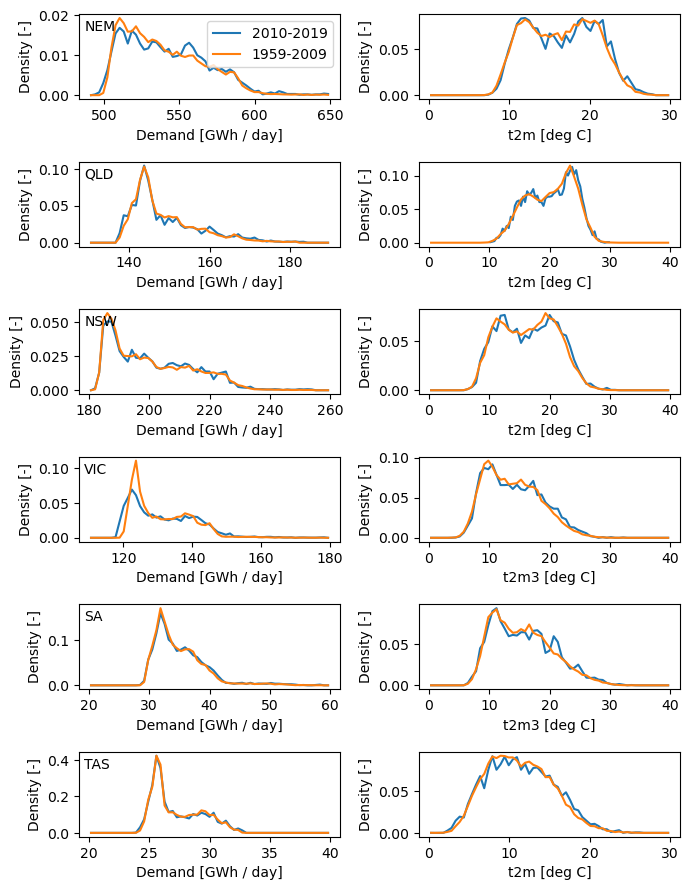

In [169]:
fig, ax = plt.subplots(6, 2, figsize=(7,9))

for i, r in enumerate(regions):
    # Demand histograms
    hists = [
        get_hist(pred_ds[r]["demand"].sel(time=slice("2010", "2019")) / 1000),
        get_hist(pred_ds[r]["demand"].sel(time=slice("1959", "2009")) / 1000)
    ]
    plot_hist(ax[i,0], hists, ["2010-2019", "1959-2009"], "Demand [GWh / day]")     

    ax[i,j].text(0.02, 0.8, r, transform=ax[i,0].transAxes)
    if i == 0:
        ax[i,0].legend()

    # Most important variable histograms
    hists = [
        get_hist(pred_ds[r][predictions[r].columns[0]].sel(time=slice("2010", "2019")) - 273.15),
        get_hist(pred_ds[r][predictions[r].columns[0]].sel(time=slice("1959", "2009")) - 273.15)
    ]
    plot_hist(ax[i,1], hists, ["2010-2019", "1959-2009"], first_vars[i] + " [deg C]")     

plt.tight_layout()

### Time series of extreme demand days

In [192]:
demand = xr.concat(
    [pred_ds[r]["demand"].expand_dims({"region": [r]}) for r in regions],
    "region"
)

In [193]:
demand

<xarray.DataArray 'demand' (region: 6, time: 23374)>
array([[            nan, 547198.53943347, 564642.12586953, ...,
        533903.71358235, 535570.01516964, 552931.9353877 ],
       [            nan, 154760.06806896, 162079.31110299, ...,
        151504.48430037, 151595.97476663, 152385.84693581],
       [            nan, 189939.36762768, 195404.72200143, ...,
        195194.04148318, 194339.46950929, 198951.59212363],
       [            nan, 136744.28540934, 142183.70395626, ...,
        120815.6468231 , 128543.57273562, 134830.27409519],
       [            nan,  45125.99098295,  38945.31821721, ...,
         31025.99996523,  32020.93819616,  36326.22459196],
       [ 25556.26288166,  24908.47515989,  24723.47203176, ...,
         25630.6081194 ,  24702.30152295,  24812.91309513]])
Coordinates:
  * time     (time) datetime64[ns] 1959-01-03 1959-01-04 ... 2022-12-31
  * region   (region) object 'NEM' 'QLD' 'NSW' 'VIC' 'SA' 'TAS'

In [211]:
q = 1 - 1 / (365 * 3)
print(q)

thresh = demand.sel(time=slice("1990", "2019")).quantile(q, "time")

0.9990867579908675


In [212]:
ext_dpy = demand.where(demand > thresh).sel(time=slice(None, "2019")).resample(time="1YS").count()

[Text(0, 0, 'NEM'),
 Text(0, 1, 'QLD'),
 Text(0, 2, 'NSW'),
 Text(0, 3, 'VIC'),
 Text(0, 4, 'SA'),
 Text(0, 5, 'TAS')]

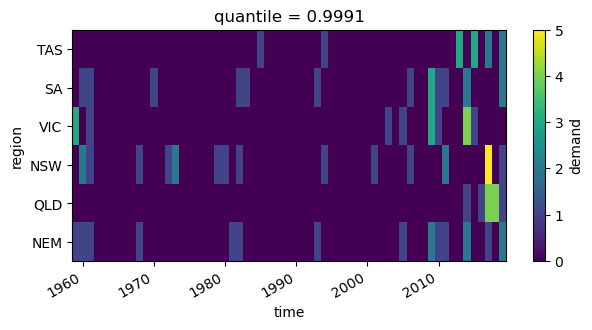

In [213]:
fig, ax = plt.subplots(1, 1, figsize=(7,3))
ext_dpy.where(ext_dpy >= 0).assign_coords({"region": range(6)}).plot(ax=ax)
ax.set_yticks(range(6))
ax.set_yticklabels(regions)

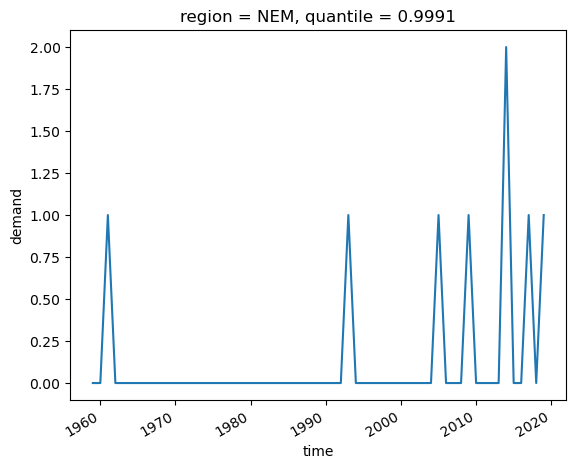

In [199]:
ext_dpy.sel(region="NEM").plot()